In [49]:
import gc
gc.collect()

105

## Data Loading and preparation

### 1-1 load all dataset

In [50]:
import pandas as pd
df = pd.read_csv("ai_hum_text.csv")
df_testA = pd.read_csv("test_Abst_A.csv")
df_testB = pd.read_csv("test_Abst_B.csv")

In [51]:
df.info()
# training dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100561 entries, 0 to 100560
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    100561 non-null  object
 1   Class   100561 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [52]:
df

,Text,Class
0,researchers have shown that using underwater i...,AI
1,this improvement signifies a more efficient al...,AI
2,however their performance can significantly de...,AI
3,this approach facilitates the documentation of...,AI
4,while rule based strategies demonstrate profic...,AI
...,...,...
100556,active learning shows promise to decrease test...,Human
100557,finally simulations using flashflow for load b...,Human
100558,in this paper we model this intention as a lat...,Human
100559,these results help to identify the most critic...,Human


In [53]:
df_testA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   clean_abstract  1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


### 1-2 Split Data

### Data Splitting Design 
- Take reference of two books -> 
    - Python for Probability, Statistics, and Machine Learning (José Unpingco)
    - Machine Learning Mastery with Python Understand Your Data, Create Accurate Models and Work Projects End-To-End (Jason Brownlee)

The dataset contains `100,561` text samples labeled as AI or Human.
Following the methodological principles of two references book above,
the data was divided into training (80%), validation (10%), and internal test (10%) subsets.

This structure reflects Unpingco’s recommendation to construct estimators on one subset (D₁) 
and evaluate them on an independent subset (D₂), while Brownlee’s 80/20 guideline 
ensures a robust yet efficient split for medium-to-large datasets. 
Within the training set, 5-fold cross-validation was employed to compare and tune 
Naive Bayes, k-Nearest Neighbors, and Logistic Regression models.

The external test sets (test_Abst_A.csv and test_Abst_B.csv) remain unseen during training and validation, and are used solely to estimate the proportion 
of AI-generated texts in real-world scenarios.

- Training set (80%): used for model fitting and cross-validation  
- Validation set (10%): used for model selection and hyperparameter tuning  
- Internal test set (10%): used for final generalization evaluation  
- External test sets (`test_Abst_A`, `test_Abst_B`): unseen, used only for estimating AI-text proportions

In [54]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['Class'],
    random_state=42
)

In [55]:
#split 20 -> validation and Test

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['Class'],
    random_state=42
)

In [56]:
print(len(train_df), len(val_df), len(test_df))
print(train_df['Class'].value_counts(normalize=True))
print(val_df['Class'].value_counts(normalize=True))
print(test_df['Class'].value_counts(normalize=True))

80448 10056 10057
Class
AI       0.623508
Human    0.376492
Name: proportion, dtype: float64
Class
AI       0.623508
Human    0.376492
Name: proportion, dtype: float64
Class
AI       0.623546
Human    0.376454
Name: proportion, dtype: float64


### 1-3 convert text sample to feature vector format

In [57]:
# X -> feature
# Y-> label(AI/hum) --> (0/1)
#count vectorizer
#TF-IDF vectorizer

In [58]:
test_df

,Text,Class
45280,addressing this gap a novel approach named the...,AI
25711,the core of echolock lies in the processing of...,AI
85368,these real world applications highly depend on...,Human
19252,weakly supervised object localization a task t...,AI
44623,intriguingly the proposed approach allows for ...,AI
...,...,...
45723,by facilitating the exploration of multi speci...,AI
91495,the best performance of our proposed method ou...,Human
81824,this paper reviews the cvpr challenge on auton...,Human
2850,for enhanced protection it is recommended to c...,AI


#### 1-3-1 count vectorizer

In [59]:
#count how mant times the word appear

In [60]:
from sklearn.feature_extraction.text import CountVectorizer
#vector
vectorizer_c = CountVectorizer(
    stop_words='english',
    ngram_range=(1,2), #(min,max) word set
    min_df=5,
    max_df=0.95, # appear over 0.95 of all text
    ) 
corpus = train_df['Text']

X_train = vectorizer_c.fit_transform(corpus) #matrix
X_train
y_train = train_df['Class']

In [61]:
vectorizer_c.get_feature_names_out()

array(['100x', '10k', '10th', ..., 'zsl', 'ztp', 'zynq'], dtype=object)

In [62]:
# X.toarray() --> too large

In [63]:
from sklearn.preprocessing import LabelEncoder
la = LabelEncoder()
Y = la.fit_transform(y_train)
Y

array([0, 1, 0, ..., 1, 1, 0])

In [64]:
X_val_cv = vectorizer_c.transform(val_df['Text'])
X_test_cv = vectorizer_c.transform(test_df['Text'])

#### 1-3-2 TF-IDF vectorizer

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tf = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    min_df=5,
    max_df=0.95,
)
X_train_tf = vectorizer_tf.fit_transform(train_df['Text'])
X_train_tf

<80448x40739 sparse matrix of type '<class 'numpy.float64'>'
	with 1456010 stored elements in Compressed Sparse Row format>

In [66]:
X_val_tf   = vectorizer_tf.transform(val_df['Text'])
X_test_tf  = vectorizer_tf.transform(test_df['Text'])

## 2. Model Training and Evaluation

Model Training
- k-nearest neighbour
- Naive bayes
- Logistic Regression

Evaluation measurement
- Accurancy
- Precision
- Recall
- F1-score
- Confusion Matrix
- Cross-Validation

### 2-1 Model Training

In [67]:
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [69]:
# Note
# Euclidean -> dense continuous numeric, low dimension
# Cosine -> high-dimensional sparse data, direction

In [70]:
#make 2 pipeline for two vectorizers respectively (basic set up as KNN)
#pipeline 1 - Count
pipe_count = make_pipeline(
    vectorizer_c,
    KNeighborsClassifier(
        n_neighbors=5,
        metric='cosine',
        weights='distance',
        algorithm='brute', #suit for high dimension
        n_jobs=-1)
)
#pipeline 2 - TF-IDF
pipe_tf = make_pipeline(
    vectorizer_tf,
    KNeighborsClassifier()
)

In [ ]:
knn = KNeighborsClassifier(
        n_neighbors=5,
        metric='cosine',
        weights='distance',
        algorithm='brute',
        n_jobs=-1)

In [72]:
# Note
# fit_prior -> True, let the model learn training set prior

In [73]:
nb = MultinomialNB(
    fit_prior=True,
    alpha=1.0
)

#### 2-1-1 K-nearest neighbor

In [74]:
pipe_count_knn = make_pipeline(
    vectorizer_c,
    knn
)
#pipeline 2 - TF-IDF
pipe_tf_knn = make_pipeline(
    vectorizer_tf,
    knn
)

In [75]:
pipe_count_knn.fit(train_df['Text'], train_df['Class'])
pipe_tf_knn.fit(train_df['Text'],train_df['Class'])

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.95, min_df=5, ngram_range=(1, 2),
                                 stop_words='english')),
                ('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='brute', metric='cosine',
                                      n_jobs=-1, weights='distance'))])

#### 2-1-2 Naive bayes

In [76]:
pipe_count_nb = make_pipeline(
    vectorizer_c,
    nb
)
#pipeline 2 - TF-IDF
pipe_tf_nb = make_pipeline(
    vectorizer_tf,
    nb
)

In [77]:
pipe_count_nb.fit(train_df['Text'], train_df['Class'])
pipe_tf_nb.fit(train_df['Text'],train_df['Class'])

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.95, min_df=5, ngram_range=(1, 2),
                                 stop_words='english')),
                ('multinomialnb', MultinomialNB())])

#### 2-1-3 Logistic Regression

In [ ]:
lr = LogisticRegression(
    penalty="l2",
    solver="liblinear",
    C=1.0,
    max_iter=1000,
    class_weight=None
)
#老師用了class_weight= 'balanced'

<mark>Analysis</mark>

Since this analysis involves a text classification task, the vectorized features exhibit extremely high dimensionality and sparse distribution. 

Therefore, the selected model must satisfy the following conditions:

1. Capable of efficiently processing high-dimensional sparse matrices;

2. Avoid overly frequent or large gradient updates to prevent computational inefficiency and unstable convergence;

3. Employ regularization to suppress overfitting caused by high-dimensional features.

Considering these factors, I selected solver=‘liblinear’ and applied L2 regularization to control weight magnitudes and enhance model generalization.

In [79]:
pipe_count_lr = make_pipeline(
    vectorizer_c,
    lr
)
#pipeline 2 - TF-IDF
pipe_tf_lr = make_pipeline(
    vectorizer_tf,
    lr
)

In [80]:
pipe_count_lr.fit(train_df['Text'], train_df['Class'])
pipe_tf_lr.fit(train_df['Text'],train_df['Class'])

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.95, min_df=5, ngram_range=(1, 2),
                                 stop_words='english')),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, solver='liblinear'))])

In [81]:
# k-nearest neighbour
# Naive bayes
# Logistic Regression

### 2-2 Evaluate measurement
- Accurancy and confusion matrix
- Precision
- Recall
- F1-score
- Cross-Validation

In [ ]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

In [83]:
y_pred_count = pipe_count_knn.predict(val_df['Text'])
y_pred_tf = pipe_tf_knn.predict(val_df['Text'])

In [84]:
y_true = val_df['Class']

#### 2-2-1-1 Accuracy and Confusion Matrix - KNN

CountVectorizer + KNN
Accurancy: 0.6135640413683373
              precision    recall  f1-score   support

          AI       0.72      0.62      0.67      6270
       Human       0.49      0.60      0.54      3786

    accuracy                           0.61     10056
   macro avg       0.60      0.61      0.60     10056
weighted avg       0.63      0.61      0.62     10056

TF-IDF + KNN
Accuracy: 0.6096857597454256
              precision    recall  f1-score   support

          AI       0.70      0.66      0.68      6270
       Human       0.48      0.53      0.51      3786

    accuracy                           0.61     10056
   macro avg       0.59      0.59      0.59     10056
weighted avg       0.62      0.61      0.61     10056



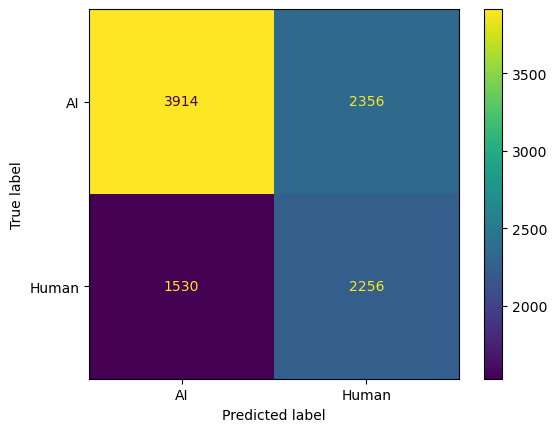

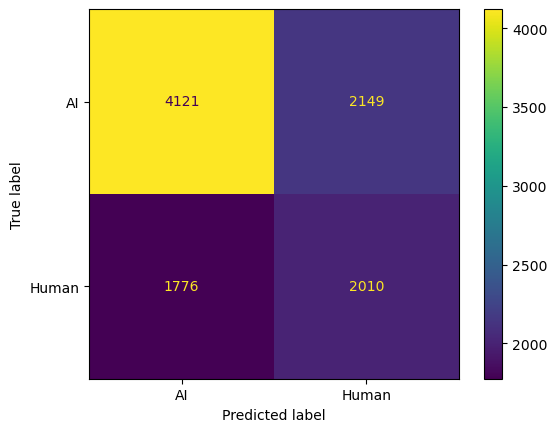

In [85]:
print("CountVectorizer + KNN")
print("Accurancy:", accuracy_score(y_true, y_pred_count))
print(classification_report(y_true,y_pred_count))
ConfusionMatrixDisplay.from_predictions(y_true,y_pred_count)

print("TF-IDF + KNN")
print("Accuracy:", accuracy_score(y_true, y_pred_tf))
print(classification_report(y_true, y_pred_tf))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred_tf)

#### 2-2-1-2 Accuracy and Confusion Matrix - Naive Bayes

In [86]:
y_pred_count = pipe_count_nb.predict(val_df['Text'])
y_pred_tf = pipe_tf_nb.predict(val_df['Text'])

CountVectorizer + Naive Bayes
Accurancy: 0.8736077963404932
              precision    recall  f1-score   support

          AI       0.89      0.91      0.90      6270
       Human       0.84      0.82      0.83      3786

    accuracy                           0.87     10056
   macro avg       0.87      0.86      0.86     10056
weighted avg       0.87      0.87      0.87     10056

TF-IDF + Naive Bayes
Accuracy: 0.8601829753381066
              precision    recall  f1-score   support

          AI       0.86      0.93      0.89      6270
       Human       0.87      0.74      0.80      3786

    accuracy                           0.86     10056
   macro avg       0.86      0.84      0.85     10056
weighted avg       0.86      0.86      0.86     10056



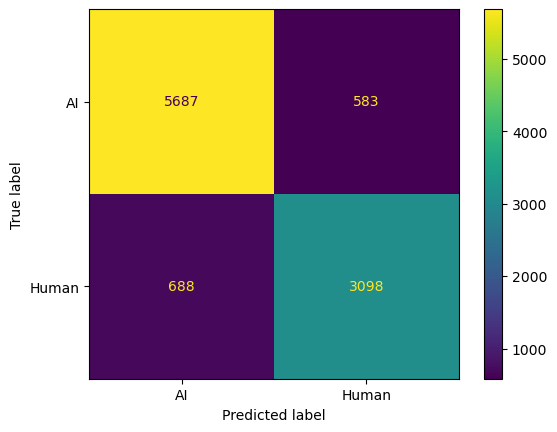

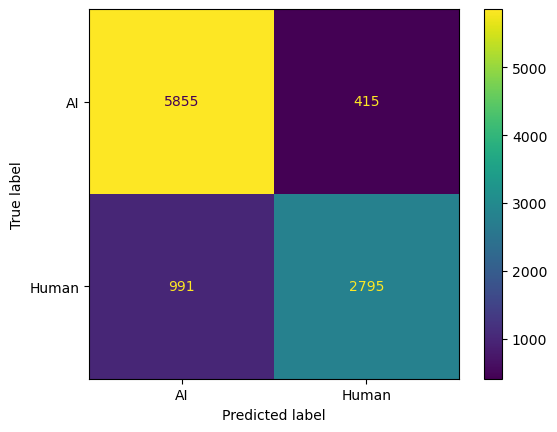

In [87]:
print("CountVectorizer + Naive Bayes")
print("Accurancy:", accuracy_score(y_true, y_pred_count))
print(classification_report(y_true,y_pred_count))
ConfusionMatrixDisplay.from_predictions(y_true,y_pred_count)

print("TF-IDF + Naive Bayes")
print("Accuracy:", accuracy_score(y_true, y_pred_tf))
print(classification_report(y_true, y_pred_tf))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred_tf)

#### 2-2-1-3 Accuracy and Confusion Matrix - Logistic Regression

In [88]:
y_pred_count = pipe_count_lr.predict(val_df['Text'])
y_pred_tf = pipe_tf_lr.predict(val_df['Text'])

CountVectorizer + Logistic Regression
Accurancy: 0.8799721559268099
              precision    recall  f1-score   support

          AI       0.87      0.95      0.91      6270
       Human       0.90      0.77      0.83      3786

    accuracy                           0.88     10056
   macro avg       0.88      0.86      0.87     10056
weighted avg       0.88      0.88      0.88     10056

TF-IDF + Logistic Regression
Accuracy: 0.8953858392999204
              precision    recall  f1-score   support

          AI       0.91      0.93      0.92      6270
       Human       0.87      0.84      0.86      3786

    accuracy                           0.90     10056
   macro avg       0.89      0.89      0.89     10056
weighted avg       0.89      0.90      0.90     10056



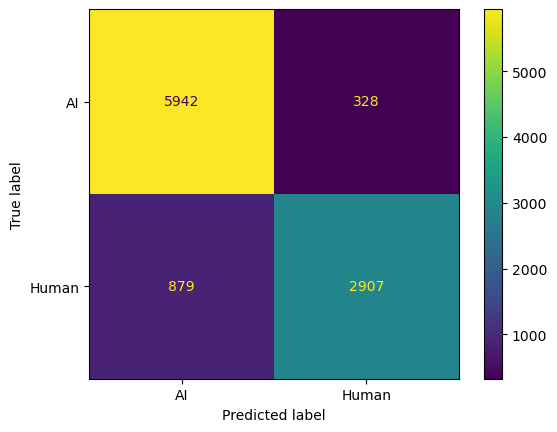

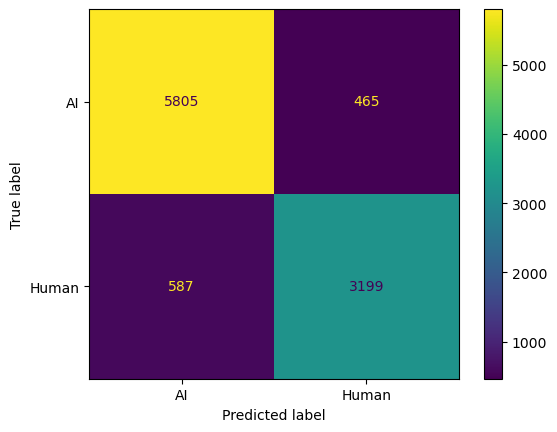

In [89]:
print("CountVectorizer + Logistic Regression")
print("Accurancy:", accuracy_score(y_true, y_pred_count))
print(classification_report(y_true,y_pred_count))
ConfusionMatrixDisplay.from_predictions(y_true,y_pred_count)

print("TF-IDF + Logistic Regression")
print("Accuracy:", accuracy_score(y_true, y_pred_tf))
print(classification_report(y_true, y_pred_tf))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred_tf)

#### 2-2-2 cross validation

In [90]:
from sklearn.model_selection import StratifiedKFold,cross_validate
cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

In [91]:
scoring = {
    "acc": "accuracy",
    "f1_macro": "f1_macro",
    "f1_weighted": "f1_weighted"
}

In [92]:
models = {
    "Count + KNN":   pipe_count_knn,
    "TFIDF + KNN":   pipe_tf_knn,
    "Count + NB":    pipe_count_nb,
    "TFIDF + NB":    pipe_tf_nb,
    "Count + LR":    pipe_count_lr,
    "TFIDF + LR":    pipe_tf_lr,
}

summary = []
for name, pipe in models.items():
    res = cross_validate(pipe, train_df["Text"], train_df["Class"],
                        cv=cv, scoring=scoring, n_jobs=-1)
    summary.append([
        name,
        res["test_acc"].mean(),        res["test_acc"].std(),
        res["test_f1_macro"].mean(),   res["test_f1_macro"].std(),
        res["test_f1_weighted"].mean(),res["test_f1_weighted"].std(),
    ])


for row in summary:
    print(f"{row[0]:<18}  acc {row[1]:.4f}±{row[2]:.4f}  "
        f"f1_macro {row[3]:.4f}±{row[4]:.4f}  f1_weighted {row[5]:.4f}±{row[6]:.4f}")

Count + KNN         acc 0.6583±0.0015  f1_macro 0.6467±0.0019  f1_weighted 0.6625±0.0016
TFIDF + KNN         acc 0.6428±0.0021  f1_macro 0.6251±0.0026  f1_weighted 0.6452±0.0022
Count + NB          acc 0.8716±0.0022  f1_macro 0.8650±0.0024  f1_weighted 0.8724±0.0022
TFIDF + NB          acc 0.8624±0.0028  f1_macro 0.8487±0.0032  f1_weighted 0.8599±0.0029
Count + LR          acc 0.9000±0.0009  f1_macro 0.8938±0.0010  f1_weighted 0.9001±0.0009
TFIDF + LR          acc 0.8955±0.0014  f1_macro 0.8880±0.0016  f1_weighted 0.8952±0.0015


Final Test Set Performance (TF-IDF + Logistic Regression)
Accuracy: 0.9004673361837526
              precision    recall  f1-score   support

          AI      0.915     0.926     0.921      6271
       Human      0.875     0.858     0.866      3786

    accuracy                          0.900     10057
   macro avg      0.895     0.892     0.894     10057
weighted avg      0.900     0.900     0.900     10057



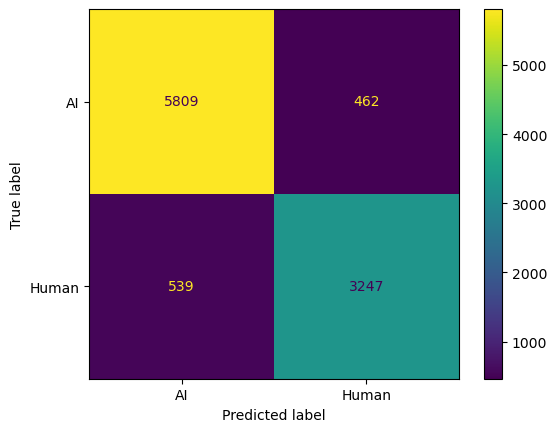

In [ ]:
# Final Evaluation on Test Set

# Combine train + validation
train_val_text = pd.concat([train_df['Text'], val_df['Text']])
train_val_class = pd.concat([train_df['Class'], val_df['Class']])

# Refit the best-performing model (TF-IDF + Logistic Regression)
pipe_tf_lr.fit(train_val_text, train_val_class)

# Predict on the unseen test set
y_test_pred = pipe_tf_lr.predict(test_df['Text'])

# Evaluate

print("Final Test Set Performance (TF-IDF + Logistic Regression)")
print("Accuracy:", accuracy_score(test_df['Class'], y_test_pred))
print(classification_report(test_df['Class'], y_test_pred, digits=3))
ConfusionMatrixDisplay.from_predictions(test_df['Class'], y_test_pred)


### Model Design Rationale

To ensure a fair and comprehensive evaluation of text representation and classification strategies,
this study compares two distinct vectorization methods (Count Vectorizer and TF-IDF)
alongside three classifiers (K-Nearest Neighbors, Naive Bayes, and Logistic Regression).

- **Count Vectorization vs. TF-IDF**  
  These methods capture lexical features at different levels of abstraction.  
  Count Vectorization reflects raw word frequencies, suitable for simple lexical statistics analysis, while TF-IDF normalizes high-frequency words and highlights information-rich terms, thereby more effectively modeling linguistic salience in long-form texts.

- **Testing of Three Classifiers**  
  - *K-Nearest Neighbors (KNN)*: A non-parametric, instance-based model serving as a baseline purely dependent on lexical distance.  
  - *Naive Bayes (NB)*: A probabilistic model assuming lexical independence, suitable for high-dimensional sparse text data. 
  - *Logistic Regression (LR)*: A linear discriminant model with L2 regularization,
    balancing interpretability, scalability, and generalization capability.

By comparing these combinations, the most effective feature-model pairing scheme can be identified
to distinguish AI-generated text from human-written text while minimizing bias arising from single modeling assumptions.

Ultimately, the **TF-IDF + Logistic Regression** combination achieved the highest validation performance,
demonstrating that TF-IDF's weighting of lexical importance, combined with a regularized linear boundary,
provides optimal generalization capabilities for this language classification task.

### 2-3 Proportion Estimation and Discussion

In [94]:
#df_testA/df_testB

In [95]:
best_model = pipe_tf_lr

In [96]:
df_testB

,clean_abstract
0,style transfer aims to synthesize an image whi...
1,this paper formulates a chanceconstrained opti...
2,this paper introduces a design scheme of intel...
3,background artificial intelligence ai has beco...
4,based on the group heuristic model and the mod...
...,...
995,agent programming languages have proved useful...
996,market competitiveness is the main driver in t...
997,we establish the existence of nonnegative weak...
998,integration of the line laser scanning system ...


In [97]:
df_testA = df_testA.rename(columns={'clean_abstract':'Text'})

In [98]:
df_testB = df_testB.rename(columns={'clean_abstract':'Text'})

In [99]:
predA = best_model.predict(df_testA['Text'])
predB = best_model.predict(df_testB['Text'])

In [100]:
import numpy as np

ai_prop_A = np.mean(predA == "AI")
ai_prop_B = np.mean(predB == "AI")

print(f"AI proportion in Test_Abst_A: {ai_prop_A:.3f}")
print(f"AI proportion in Test_Abst_B: {ai_prop_B:.3f}")

AI proportion in Test_Abst_A: 0.309
AI proportion in Test_Abst_B: 0.074


Key Findings

This study trained a lexical feature-based classification model using Logistic Regression combined with TF-IDF vectorization.
It was applied to two unlabeled abstract collections (Test_Abst_A and Test_Abst_B) to estimate their linguistic similarity to known AI-generated text.

Using the best-performing classifier (TF-IDF + Logistic Regression),
I estimated the proportion of AI-generated texts in the two unlabeled test sets.

| Dataset | AI Proportion |
|----------|---------------|
| Test_Abst_A | 31.0% |
| Test_Abst_B | 7.0% |

- What can be confidently concluded
    - The classifier stably detects stylistic differences between AI and Human texts.
    - Test_Abst_A shows a substantially higher proportion of AI-like language patterns than Test_Abst_B.
    - Given the model’s strong validation performance, the relative difference between datasets is likely reliable.
    - These percentages reflect the degree of linguistic similarity between the abstract collections and AI texts in the training data.
    - The model demonstrates strong generalization and stability, allowing us to reasonably infer that Test_Abst_A's linguistic style is closer to AI-like text.

-  What Cannot Be Concluded
    - These proportions do not represent the actual AI generation rates or true author identities.
    - The model identifies linguistic similarity to AI writing, not the actual authorship or generation source.
    - Domain or stylistic differences between datasets may bias the estimates.
    - The results should be interpreted as *indicative trends* rather than definitive proof.
    - Since model accuracy is not 100%, prediction ratios for individual datasets may still be overestimated or underestimated.
    - If external test data exhibits significant domain shift, classification reliability decreases.